## Load the data

In [1]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from scipy.stats import nbinom, poisson
from time import sleep
from tqdm import tqdm
import warnings


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])

country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

## Länder aussortieren
die nicht gefordert sind und
*  die keine actuals haben
*  die zu wenig Beobachtungen haben

In [2]:
relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV-Datei einlesen und als Pandas-Datensatz speichern
countryList_prediction = pd.read_csv(path_countrylist)
country_list_views = countryList_prediction.loc[:,'country_id'].values.tolist() 

month_list = []
countries_to_remove = []
for country_id in country_list:

    if country_id in country_list_views:
        feature_data = country_feature_group_list[0].get_group(country_id)

        # numbers of months from the feature dataset
        month_list_feature_data_original = feature_data.index.get_level_values('month_id').tolist()
        number_months_feature_data = len(month_list_feature_data_original) 

        if check_Actuals(country_id, 0):
            if not check_last_featureMonth(country_id, 0): 
                month_list.append([str(country_id) +' last month missing'])
            else:
                month_list.append([number_months_feature_data, country_id])
        else:
            month_list.append(str(country_id) + ' no actuals')
    else:
        countries_to_remove.append(country_id)

country_list = list(set(country_list) - set(countries_to_remove))
month_list.sort()

check for possible Nan's in all Datasets

In [3]:
# check for nan's
for featurelist in features_df_list:
    is_na_series = featurelist['data'].isna().sum()

    for i in range(len(is_na_series)):
        if is_na_series[i] > 0 :
            print(str(is_na_series.index[i]) + ': ' + str(is_na_series[i]))

## Feed forward Neural Net
Goal is to estimate the empirical distribution of the fatalities per month.

### CRPS Loss function
CRPS for samples from random variables with a finite first moment.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
import matplotlib.pyplot as plt
import seaborn as sns

# crps loss function 
def crps(y_true, S):
    """
    Computes continuous ranked probability score:

    Parameters
    ----------
    y_true : tf tensor of shape (BATCH_SIZE, 1)
        True values.
    S : tf tensor of shape (BATCH_SIZE, N_SAMPLES)
        Predictive samples.

    Returns
    -------
    tf tensor of shape (BATCH_SIZE,)
        Scores.

    """
    beta=1
    n_samples = S.shape[-1]
    def expected_dist(diff, beta):
        return K.sum(K.pow(K.sqrt(K.square(diff)+K.epsilon()), beta),axis=-1) #axis = -1: last dimension <=> N_SAMPLES
    es_1 = expected_dist(y_true - S, beta)
    es_2 = 0
    for i in range(n_samples):
        es_2 = es_2 + expected_dist(K.expand_dims(S[:,i]) - S, beta)
    return es_1/n_samples - es_2/(2*n_samples**2)

class CRPSLoss(Loss):
    def call(self, y_true, S):
        return crps(y_true, S)

### Data preparation for the Neural Net

In [5]:
import math
from sklearn import model_selection, preprocessing
### function used to calculate w_max, number of rolling windows etc.
# length of a whole window (containing w input months and 12 acutal months)
def rollingWindowLength(w):
    return w + 2 + 12

def number_valid_months(numberMonths_available, w, relative_validation_size):
    rollingWindowlen = rollingWindowLength(w)

    number_train_valid_months = numberMonths_available - w
    number_valid_months = math.floor(number_train_valid_months * relative_validation_size)

    return number_valid_months

# number of months available for training (after removing the validation and test months)
def number_train_months(numberMonths_available, w, relative_validation_size):
    rollingWindowlen = rollingWindowLength(w)
    
    valid_months = number_valid_months(numberMonths_available, w, relative_validation_size)

    #  all months feature data     validate set          test set input
    return numberMonths_available - valid_months - w


def number_rolling_windows(numberMonths_available, w):
    return max(0,numberMonths_available - rollingWindowLength(w) + 1)

""" # number of training samples (rolling windows)
def number_train_samples(numberMonths_available, w, relative_validation_size):
    rollingWindowlen = rollingWindowLength(w)
    return number_train_months(numberMonths_available, w, relative_validation_size) - rollingWindowlen """

""" # calculate the w_max ( 0 < w_max < 49), so that there are "numberSamples_required" rolling windows
def get_maximal_w(numberSamples_required, numberMonths_available, relative_validation_size):

    w_max = 1

    if number_train_samples(numberMonths_available, w_max, relative_validation_size) < numberSamples_required:
        raise ValueError('not enough months for ' + str(numberSamples_required) + ' required samples')
         

    sampleSize = number_train_samples(numberMonths_available, w_max, relative_validation_size)

    while sampleSize > numberSamples_required:
        w_max += 1
        sampleSize = number_train_samples(numberMonths_available, w_max, relative_validation_size)

    return w_max """


### prediction task for year 2018
prediction_year = '2018'
dataset_index = actual_years.index(prediction_year)
s = 3 # month to predict

rel_validation_size = 0.3 # percentual size of the validation set

# the maximal w (months to estimate the fatalities from) is set to e.g. 3 years (36 months) 
w_max = 36
"""  diese HERANGEHENSWEISE funktioniert so nicht für länder mit wenig monaten...!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! """
""" # For years that have less number of months, not the samplesize (=number of rolling windows), but the w_max is reduced, so that
# the number of samples for the prediction stays the same:
# the reference for the minimal samplesize (=number of rolling windows) with the biggest w_max is the number of
# possible rolling windows for a country, that has all months of observartions, starting from 1991 to oct of the
# year before the prediction year.
number_req_samples = number_train_samples(number_months_feature_data, w_max, rel_validation_size)
print('required samples: ' + str(number_req_samples)) """


## country 223
prediction_country_id = 223
w = 36

# check if the last month of the country in the feature dataset is 3 months before the first month that has to be predicted
if not check_last_featureMonth(prediction_country_id, dataset_index):
    raise ValueError('last month is not contained in the data')

## load datasets
feature_data = country_feature_group_list[dataset_index].get_group(prediction_country_id)
actual_data = country_actual_group_list[dataset_index].get_group(prediction_country_id)

# numbers of months from the feature dataset
month_list_feature_data = feature_data.index.get_level_values('month_id').tolist()
first_month = min(month_list_feature_data)
last_month = max(month_list_feature_data)
number_months_feature_data = len(month_list_feature_data) # number of months in the feature dataset


### split data in train-, validation- and test-dataset
""" The data sizes are calculated in a way, that missing months are no problem. Additionaly due to the fact, that the data is sorted
    regarding months, this step can be skipped. """



""" # calculate the w_max so that there are "required_samples" rolling windows for the prediction
w_max = get_maximal_w(number_req_samples, number_months_feature_data, rel_validation_size) """

#----------------------------------------------
""" 
    LIST MIT ALLEN LÄNDER ERSTELLEN, DIE W_MAX = x HABEN (also alle Monate verfügbar sind),
    um bei diesen Einfluss der Windowgröße auf das Schätzergebnis zu ermitteln

 """

# length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
roll_window_len = rollingWindowLength(w)
n_train_months = number_train_months(number_months_feature_data, w, rel_validation_size)
n_valid_months = number_valid_months(number_months_feature_data, w, rel_validation_size)
n_test_months = w

month_list_train = month_list_feature_data[0:n_train_months]
month_list_valid = month_list_feature_data[n_train_months:(n_train_months+n_valid_months)]
month_list_test = month_list_feature_data[number_months_feature_data-n_test_months:]

## training dataset------
X_train = []
Y_train = []

number_rolling_windows_train = number_rolling_windows(n_train_months, w)

for i in range(0, number_rolling_windows_train):
    starting_month_features = month_list_train[i]

    index_ending_month_features = i + w - 1
    ending_month_features = month_list_train[index_ending_month_features]

    starting_month_unrActuals = month_list_train[index_ending_month_features + 3]
    ending_month_unrActuals = month_list_train[index_ending_month_features + 14]

    window_features = feature_data.loc[slice(starting_month_features, ending_month_features), 'ged_sb':'ged_sb_tlag_4'] # excluding "unreal" actuals
    window_actuals = feature_data.loc[slice(starting_month_unrActuals, ending_month_unrActuals), 'ged_sb'].iloc[s - 3] # "unreal" actuals


    normalized_window_features = preprocessing.normalize(window_features)
    window_features_array = np.array([normalized_window_features.flatten()])[0]

    window_actual_array = np.array([window_actuals])

    X_train.append(window_features_array)
    Y_train.append(window_actual_array)

X_train = np.array(X_train)
Y_train = np.array(Y_train)



## validation dataset--------
X_validate = []
Y_validate = []

number_rolling_windows_validate = number_rolling_windows(n_valid_months, w)

for i in range(0, number_rolling_windows_validate):
    starting_month_features = month_list_valid[i]

    index_ending_month_features = i + w - 1
    ending_month_features = month_list_valid[index_ending_month_features]

    starting_month_unrActuals = month_list_valid[index_ending_month_features + 3]
    ending_month_unrActuals = month_list_valid[index_ending_month_features + 14]

    window_features = feature_data.loc[slice(starting_month_features, ending_month_features), 'ged_sb':'ged_sb_tlag_4'] # excluding "unreal" actuals
    window_actuals = feature_data.loc[slice(starting_month_unrActuals, ending_month_unrActuals), 'ged_sb'].iloc[s - 3] # "unreal" actuals


    normalized_window_features = preprocessing.normalize(window_features)
    window_features_array = np.array([normalized_window_features.flatten()])[0]

    window_actual_array = np.array([window_actuals])

    X_validate.append(window_features_array)
    Y_validate.append(window_actual_array)

X_validate = np.array(X_validate)
Y_validate = np.array(Y_validate)

## test dataset-------
X_test = []
Y_test = []

starting_month_test = month_list_test[0]
ending_month_test = month_list_test[-1]

window_features_test = feature_data.loc[slice(starting_month_test, ending_month_test), 'ged_sb':'ged_sb_tlag_4'] # excluding "unreal" actuals
window_actuals_test = actual_data.iloc[s - 3].values # "unreal" actuals

normalized_window_features_test = preprocessing.normalize(window_features_test)
window_features_array_test = np.array([normalized_window_features_test.flatten()])[0]

window_actual_array_test = window_actuals_test

X_test.append(window_features_array_test)
Y_test.append(window_actual_array_test)

X_test = np.array(X_test)
Y_test = np.array(Y_test)


print('(first, last) train month: (' + str(month_list_train[0])+','+str(month_list_train[-1])+')')
print('(first, last) validate month: (' + str(month_list_valid[0])+','+str(month_list_valid[-1])+')')
print('(first, last) test month: (' + str(month_list_test[0])+','+str(month_list_test[-1])+')')
print('train + valid + test = ' + str(n_train_months + n_valid_months +n_test_months) + ' != ' + str(number_months_feature_data))


print('')
print('# rolling w train: ' + str(number_rolling_windows_train) + '      # rolling w validate: ' + str(number_rolling_windows_validate))


(first, last) train month: (121,329)
(first, last) validate month: (330,418)
(first, last) test month: (419,454)
train + valid + test = 334 != 334

# rolling w train: 160      # rolling w validate: 40


In [6]:
len(X_test[0])

432

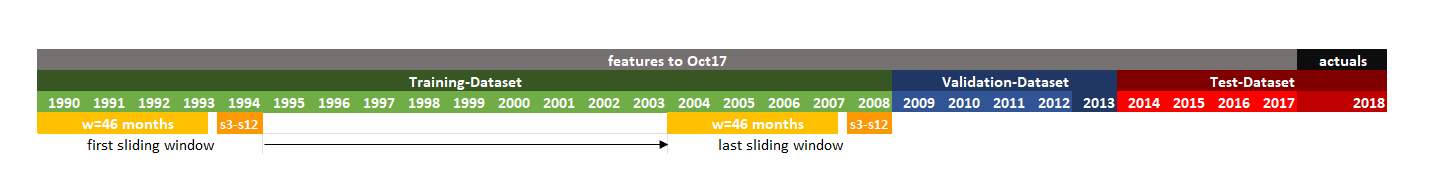

### Rolling window split for the current windowlength w
As shown in the picture above, the training dataset is genereated via a rolling window approach.
**One sample contains:**
*  features of w months, concatenated to one vector with the dimension *w * number_of_features*
*  one true observation, dependent of the current s that is estimated in the NN, e.g. y_true = s3 = 54.

So one entire training sample for a w contains a different amount of samples, dependent from the windowlength and the available number of observations of the country.

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.compat.v2.enable_v2_behavior()
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


from scipy.stats import nbinom

# Funktion für die ReLU-Transformation
def relu_transform(x):
    return tf.nn.relu(x)


## hyperparameters
batchSize = 1 # defines the number of samples to work through before 
# updating the internal model parameters (sample = (1 inputvector, 1 y_true))
epochSize = 2 # defines the number times that the learning algorithm will work through the entire training dataset
# -> line plots that show epochs along the x-axis as time and the error or skill of the model on the y-axis (= learning curve)
learningRate = 0.001


input_shape = (len(X_train[0]),) # Number of used features   10 * 32
# z.B.
""" [
  [1, 2, 3, ..., 10],   # Datenpunkt 1 mit 10 features
  [11, 12, 13, ..., 20],  # Datenpunkt 2 mit 10 features
  ...
  [311, 312, 313, ..., 320]  # Datenpunkt 32 mit 10 features
] """


# Define inputs with predefined shape
inputs = Input(shape=input_shape)

# print(inputs.shape) -> (None, 10, 32) no Batch size defined (more flexible)

hidden_layer1 = Dense(20, activation='relu')(inputs) 
# Dense Layer: the 10 neurons in the dense layer get their source of input data 
# from all the other neurons of the previous layer of the network (= fully connected layer)
#hidden_layer2 = Dense(8, activation='relu')(hidden_layer1) 

#
output_s3 = Dense(200)(hidden_layer1)
sample_output_s3 = Lambda(relu_transform)(output_s3)

# Construct model
model = Model(inputs=inputs, outputs=sample_output_s3, name = 'simple_NN_empirical')

# Compile the model with the desired optimizer, loss function, etc.
model.compile(optimizer=Adam(learning_rate=learningRate), loss=CRPSLoss())


# Print model summary
model.summary()

Model: "simple_NN_empirical"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 432)]             0         
                                                                 
 dense (Dense)               (None, 20)                8660      
                                                                 
 dense_1 (Dense)             (None, 200)               4200      
                                                                 
 lambda (Lambda)             (None, 200)               0         
                                                                 
Total params: 12860 (50.23 KB)
Trainable params: 12860 (50.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
history = model.fit(X_train, Y_train, 
                    batch_size=batchSize, epochs=epochSize,
                    validation_data=(X_validate, Y_validate))

test_scores = model.evaluate(X_test, Y_test, verbose=2)
print("Test loss:", test_scores)

Epoch 1/2
160/160 [==============================] - 32s 40ms/step - loss: 119.8433 - val_loss: 31.4392
Epoch 2/2
160/160 [==============================] - 1s 7ms/step - loss: 96.4611 - val_loss: 16.6284
1/1 - 5s - loss: 15.0851 - 5s/epoch - 5s/step
Test loss: 15.085064888000488


In [9]:
history.history

{'loss': [119.84332275390625, 96.4610595703125],
 'val_loss': [31.4392032623291, 16.628398895263672]}

In [11]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=1)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate prediction")
prediction = model.predict(X_test)
print("predictions shape:", prediction.shape)

Evaluate on test data
1/1 [==============================] - 0s 54ms/step - loss: 15.0851
test loss, test acc: 15.085060119628906
Generate prediction
1/1 [==============================] - 0s 50ms/step
predictions shape: (1, 200)


In [12]:
empirical_distribution = np.round(np.sort(prediction[0])).astype(int)
empirical_distribution

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 19, 51, 52, 53, 53, 54, 54, 54, 54,
       55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 58, 58, 58,
       58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60,
       60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61,
       61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63,
       63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64,
       64, 65, 65, 65, 65, 65, 65, 66, 66, 66, 67, 68, 69])

In [13]:
y_true = Y_test[0][0]
crps = pscore(empirical_distribution,y_true).compute()[0]
print('CRPS = ' + str(crps))

CRPS = 15.094499999999996


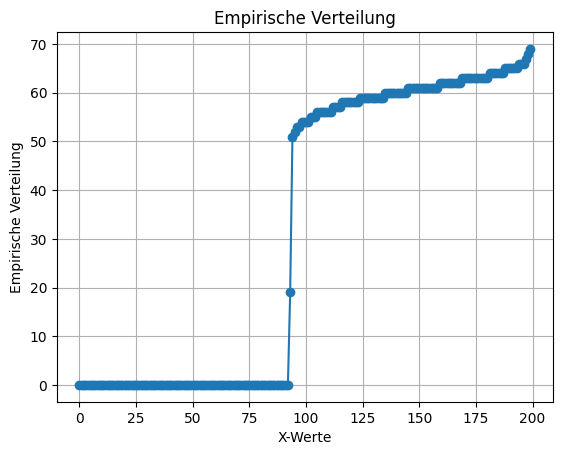

In [14]:
import matplotlib.pyplot as plt
# Die X-Werte sind die Indizes des Arrays (von 0 bis zur Länge des Arrays)
x = np.arange(len(empirical_distribution))

# Plot erstellen
plt.plot(x, empirical_distribution, marker='o', linestyle='-')
plt.xlabel('X-Werte')
plt.ylabel('Empirische Verteilung')
plt.title('Empirische Verteilung')
plt.grid(True)
plt.show()